### TEST

In [2]:
import tensorflow as tf
BASE_DIR = os.getcwd()
model_path = os.path.join(BASE_DIR, 'models', 'efficientnet_model_final.keras')
model = tf.keras.models.load_model(model_path, compile=False)
    # Find the last convolutional layer
conv_layer = None
for layer in reversed(model.get_layer("efficientnetb0").layers):
    print(layer.name)
    if isinstance(layer, tf.keras.layers.Conv2D) or 'conv' in layer.name.lower():
        if len(layer.output_shape) == 4:  # Ensure it's a conv layer
            conv_layer = layer
            break

2025-09-17 11:32:43.078191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-17 11:32:43.078223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-17 11:32:43.079059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-17 11:32:43.084088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 11:32:43.777507: W tensorflow/compiler/tf2

NameError: name 'os' is not defined

### FUNCTION (AI-GEN, NEEDS TO BE REWORKED)

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import cv2
import numpy as np

def preprocess_image_combined(image_path, target_size=(224, 224)):
    """
    Load an image, apply CLAHE-based preprocessing, and prepare for EfficientNet.
    - Reads from file path
    - Converts to grayscale, applies CLAHE
    - Expands back to 3 channels
    - Normalizes to [0, 1]
    - Returns batched image (1, H, W, 3)
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize
    gray = cv2.resize(gray, target_size)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    
    # Stack to 3 channels (EfficientNet expects RGB-like input)
    clahe_img = np.stack([clahe_img]*3, axis=-1)
    
    # Normalize to [0, 1]
    clahe_img = clahe_img.astype(np.float32) / 255.0
    
    # Expand dims for batch
    clahe_img = np.expand_dims(clahe_img, axis=0)
    
    return clahe_img

def preprocess_image_standard(image_path, target_size=(224, 224)):
    """Standard image preprocessing without custom EfficientNet preprocessing"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image
    image = cv2.resize(image, target_size)
    
    # Convert to float32 and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    # Expand dimensions for batch
    image = np.expand_dims(image, axis=0)
    
    return image

def create_functional_model_from_loaded(loaded_model):
    """Create a new functional model to avoid graph disconnection issues"""
    
    # Create a new input layer
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    
    # Get the EfficientNet base model
    efficientnet_base = loaded_model.get_layer('efficientnetb0')
    
    # Create new EfficientNet base with fresh input
    new_base = tf.keras.applications.EfficientNetB0(
        weights=None,
        include_top=False,
        input_tensor=input_layer,
        input_shape=(224, 224, 3)
    )
    
    # Copy weights from loaded model to new base
    try:
        for i, layer in enumerate(new_base.layers):
            if i < len(efficientnet_base.layers):
                original_layer = efficientnet_base.layers[i]
                if layer.get_weights():
                    layer.set_weights(original_layer.get_weights())
    except Exception as e:
        print(f"Warning: Could not copy all weights: {e}")
    
    # Build the complete model
    x = new_base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model
    new_model = tf.keras.models.Model(inputs=input_layer, outputs=predictions)
    
    # Copy the final dense layer weights
    try:
        # Find the dense layer in the original model
        dense_layer = None
        for layer in loaded_model.layers:
            if 'dense' in layer.name.lower():
                dense_layer = layer
                break
        
        if dense_layer is not None:
            dense_weights = dense_layer.get_weights()
            new_model.layers[-1].set_weights(dense_weights)  # Last layer should be dense
            print("Successfully copied dense layer weights")
        else:
            print("No dense layer found in original model")
    except Exception as e:
        print(f"Warning: Could not copy dense layer weights: {e}")
    
    return new_model, new_base

def make_heatmap_v2(model, image, conv_layer, class_index=0):
    """Improved heatmap generation with better error handling"""
    
    # Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        
        # Handle different prediction formats
        if predictions.shape[-1] == 1:
            # Binary classification
            loss = predictions[:, 0]
        else:
            # Multi-class classification
            loss = predictions[:, class_index]

    # Calculate gradients
    grads = tape.gradient(loss, conv_outputs)
    
    if grads is None:
        raise ValueError("Could not compute gradients. Check model connectivity.")
    
    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply feature maps by their importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.reduce_max(heatmap)
    if max_heat != 0:
        heatmap = heatmap / max_heat
    
    return heatmap.numpy()

def show_heatmap_on_image(img_path, heatmap, alpha=0.4, save_path=None):
    """Display heatmap overlaid on original image"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    
    # Apply colormap
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_INFERNO)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose
    superimposed = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_colored, alpha, 0)
    
    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap_resized, cmap='inferno')
    axes[1].set_title('Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(superimposed)
    axes[2].set_title('Superimposed')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

def gen_heatmap_robust(img_name):
    """Most robust heatmap generation method"""
    BASE_DIR = os.getcwd()
    model_path = os.path.join(BASE_DIR, 'models', 'efficientnet_model_final.keras')
    
    try:
        print("Loading original model...")
        original_model = tf.keras.models.load_model(model_path, compile=False)
        print("Original model loaded successfully")
        
        print("Creating functional model to avoid graph issues...")
        model, base_model = create_functional_model_from_loaded(original_model)
        
        print("New model created successfully")
        
    except Exception as e:
        print(f"Could not load original model: {e}")
        print("Creating fresh model with ImageNet weights...")
        
        # Fallback: create fresh model
        input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
        base_model = tf.keras.applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_tensor=input_layer
        )
        
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        model = tf.keras.models.Model(inputs=input_layer, outputs=predictions)
    
    # Find the last convolutional layer
    conv_layer = None
    for layer in reversed(base_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or 'conv' in layer.name.lower():
            if len(layer.output_shape) == 4:  # Ensure it's a conv layer
                conv_layer = layer
                break
    
    if conv_layer is None:
        print("Could not find suitable convolutional layer")
        return
    
    print(f"Using convolutional layer: {conv_layer.name}")
    print(f"Layer output shape: {conv_layer.output_shape}")
    
    # Process image
    example_image = os.path.join(BASE_DIR, 'Datasets', "MergedData", 'test', 'abnormal', img_name)
    
    if not os.path.exists(example_image):
        print(f"Image not found: {example_image}")
        return
    
    try:
        # Use standard preprocessing instead of custom EfficientNet preprocessing
        img = preprocess_image_combined(example_image)
        print(f"Image shape after preprocessing: {img.shape}")
        print(f"Image value range: [{img.min():.3f}, {img.max():.3f}]")
        
        # Test prediction
        prediction = 1 - model.predict(img)
        print(f"Model prediction: {prediction}")
        
        if np.isnan(prediction).any():
            print("Warning: Model prediction contains NaN values")
            print("This might indicate an issue with the model or preprocessing")
            # Try with different preprocessing
            img_alt = cv2.imread(example_image)
            img_alt = cv2.cvtColor(img_alt, cv2.COLOR_BGR2RGB)
            img_alt = cv2.resize(img_alt, (224, 224))
            img_alt = tf.keras.applications.efficientnet.preprocess_input(img_alt)
            img_alt = np.expand_dims(img_alt, axis=0)
            prediction_alt = model.predict(img_alt)
            print(f"Alternative preprocessing prediction: {prediction_alt}")
            if not np.isnan(prediction_alt).any():
                img = img_alt
                prediction = prediction_alt
        
        # Generate heatmap
        heatmap = make_heatmap_v2(model, img, conv_layer)
        print(f"Heatmap generated successfully. Shape: {heatmap.shape}")
        
        # Display results
        show_heatmap_on_image(example_image, heatmap)
        
        return model, heatmap
        
    except Exception as e:
        print(f"Error generating heatmap: {e}")
        import traceback
        traceback.print_exc()

# Simple alternative using tf.keras built-in functions
def gen_heatmap_simple(img_name):
    """Simplified approach using TensorFlow's built-in preprocessing"""
    BASE_DIR = os.getcwd()
    
    # Create a fresh model
    print("Creating simple EfficientNet model...")
    model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=True,
        input_shape=(224, 224, 3)
    )
    
    # Find last conv layer
    for layer in reversed(model.layers):
        if len(layer.output.shape) == 4:
            last_conv_layer = layer
            break
    
    print(f"Using layer: {last_conv_layer.name}")
    
    # Load and preprocess image
    example_image = os.path.join(BASE_DIR, 'Datasets', "MergedData", 'test', 'abnormal', img_name)
    
    img = cv2.imread(example_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_array = tf.keras.applications.efficientnet.preprocess_input(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {preds[0][predicted_class]:.3f}")
    
    # Generate heatmap
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer.output
        preds = model(img_array)
        class_channel = preds[:, predicted_class]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()[0]
    
    show_heatmap_on_image(example_image, heatmap)

def testModel(img_name):
    
    print("=== Method 1: Direct approach with original model ===")
    try:
        model, heatmap = gen_heatmap_direct(img_name)
        if model is not None:
            print("Direct method succeeded!")
        else:
            raise Exception("Direct method returned None")
    except Exception as e:
        print(f"Direct method failed: {e}")
        
        print("\n=== Method 2: Robust reconstruction method ===")
        try:
            gen_heatmap_robust(img_name)
        except Exception as e:
            print(f"Robust method failed: {e}")
            
            print("\n=== Method 3: Simple ImageNet fallback ===")
            gen_heatmap_simple(img_name)

<hr/>

# <b>TEST MODEL</b>

<hr/>

=== Method 1: Direct approach with original model ===
Direct method failed: name 'gen_heatmap_direct' is not defined

=== Method 2: Robust reconstruction method ===
Loading original model...
Original model loaded successfully
Creating functional model to avoid graph issues...
Successfully copied dense layer weights
New model created successfully
Using convolutional layer: top_conv
Layer output shape: (None, 7, 7, 1280)
Image shape after preprocessing: (1, 224, 224, 3)
Image value range: [0.024, 0.933]
1/1 [==============================] - 1s 810ms/step
Model prediction: [[0.5020387]]
Heatmap generated successfully. Shape: (7, 7)


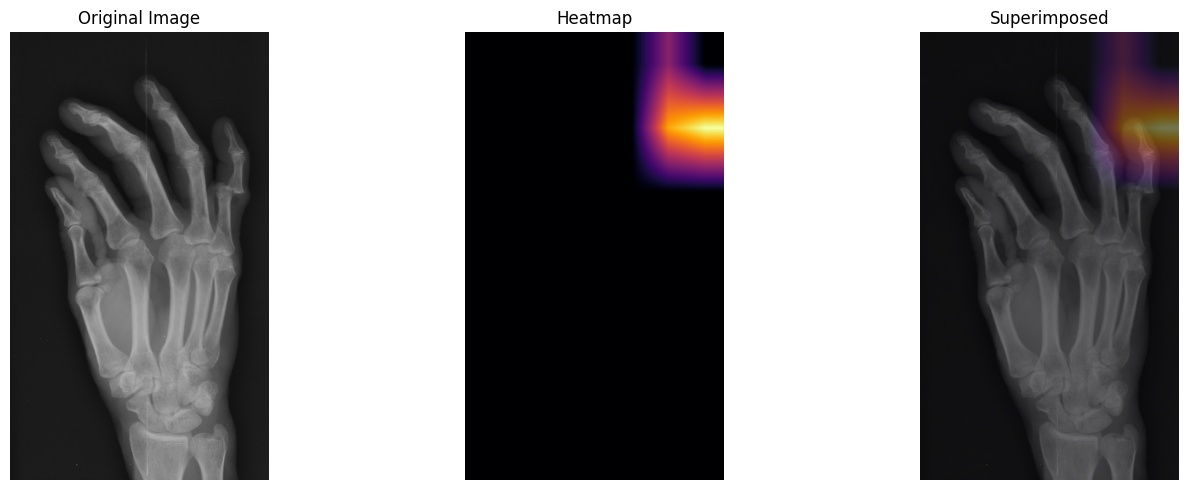

In [6]:
img = "153.jpg"
testModel(img)